# Basic examples of Xsuite
### Import some packages

In [1]:
import xtrack as xt
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import warnings

### Make a simple optics line

In [2]:
# Create an environment
env = xt.Environment()

# Define a variable in the environment
env['k1'] = 1

# Define the components of the lattice
my_components = [
    # a marker at the beginning of the lattice
    env.new('start', xt.Marker), 
    # a quadrupole of length of 1 [m] and k1 equal to 1 [1/m^2]
    env.new('qf', xt.Quadrupole, length=1, k1='k1', k1s=0.0), 
    # a drift of length of 1 [m]
    env.new('drift_1',  xt.Drift, length=1),
    env.new('qd', xt.Quadrupole, length=1, k1='-k1'),
    env.new('drift_2',  xt.Drift, length=1),
    # a marker at the end of the lattice
    env.new('end', xt.Marker), 
]

# Build the simplest stable lattice
line = env.new_line(components=my_components)

# Define reference particle
line.particle_ref = xt.Particles(p0c=7e12, mass0=xt.PROTON_MASS_EV)

### Twiss and plot

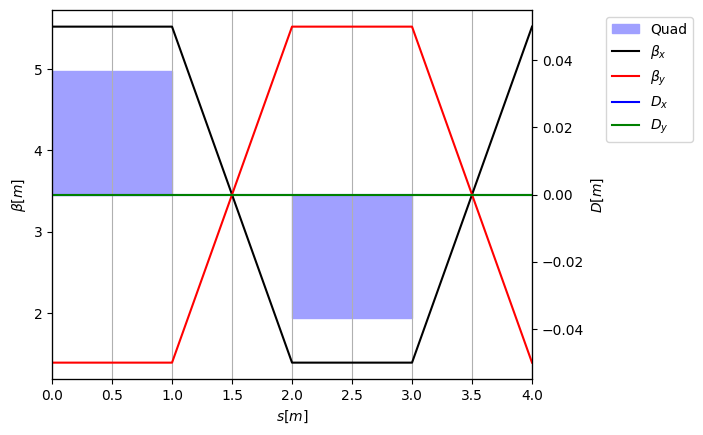

In [3]:
# Twiss in 4d 
my_twiss = line.twiss4d()
my_twiss.plot()

In [4]:
# Look at the twiss results
my_twiss.to_pandas()[['s','name','betx','bety','alfx','alfy','mux','muy']]

,s,name,betx,bety,alfx,alfy,mux,muy
0,0.0,start,5.523076,1.388529,-2.940645,1.193902,0.000000,0.000000
1,0.0,qf,5.523076,1.388529,-2.940645,1.193902,0.000000,0.000000
2,1.0,drift_1,5.523076,1.388529,2.940645,-1.193902,0.024343,0.160607
3,2.0,qd,1.388529,5.523076,1.193902,-2.940645,0.083143,0.219407
4,3.0,drift_2,1.388529,5.523076,-1.193902,2.940645,0.243750,0.243750
5,4.0,end,5.523076,1.388529,-2.940645,1.193902,0.302550,0.302550
6,4.0,_end_point,5.523076,1.388529,-2.940645,1.193902,0.302550,0.302550


In [5]:
#Check if a matrix is symplectic
OTM = my_twiss.get_R_matrix(start='start', end='end')
pd.DataFrame(OTM)

,0,1,2,3,4,5
0,-3.106017,5.224743,0.000000,0.000000,0.000000e+00,0.000000e+00
1,-1.652391,2.457592,0.000000,0.000000,0.000000e+00,0.000000e+00
2,0.000000,0.000000,0.805200,1.313526,0.000000e+00,0.000000e+00
3,0.000000,0.000000,-1.652391,-1.453625,0.000000e+00,0.000000e+00
4,0.000000,0.000000,0.000000,0.000000,1.000000e+00,-2.306867e-17
5,0.000000,0.000000,0.000000,0.000000,7.288001e-08,1.000000e+00


In [6]:
def is_symplectic(M):
    """Check if the matrix M is symplectic."""
    n = M.shape[0] // 2
    # Construct the symplectic matrix Omega
    my_block = np.array([[0, 1], [-1, 0]])
    omega = np.kron(np.eye(n), my_block)
    return np.allclose(M.T @ omega @ M, omega)

assert is_symplectic(OTM)

Remember the matrix of a thick focusing quadrupole

$\left(
\begin{array}{cc}
 \cos \left(\sqrt{\text{K1}} L\right) & \frac{\sin \left(\sqrt{\text{K1}} L\right)}{\sqrt{\text{K1}}} \\
 -\sqrt{\text{K1}} \sin \left(\sqrt{\text{K1}} L\right) & \cos \left(\sqrt{\text{K1}} L\right) \\
\end{array}
\right)$


and the one of a thick defocusing quadrupole

$\left(
\begin{array}{cc}
 \cosh \left(\sqrt{\text{K1}} L\right) & \frac{\sinh \left(\sqrt{\text{K1}} L\right)}{\sqrt{\text{K1}}} \\
 -\sqrt{\text{K1}} \sinh \left(\sqrt{\text{K1}} L\right) & \cosh \left(\sqrt{\text{K1}} L\right) \\
\end{array}
\right)$.


In [7]:
qf_matrix = my_twiss.get_R_matrix(start='qf', end='drift_1')
pd.DataFrame(qf_matrix)

,0,1,2,3,4,5
0,0.540302,0.841471,0.000000,0.000000,0.000000e+00,0.000000e+00
1,-0.841471,0.540302,0.000000,0.000000,0.000000e+00,0.000000e+00
2,0.000000,0.000000,1.543081,1.175201,0.000000e+00,0.000000e+00
3,0.000000,0.000000,1.175201,1.543081,0.000000e+00,0.000000e+00
4,0.000000,0.000000,0.000000,0.000000,1.000000e+00,-1.894642e-16
5,0.000000,0.000000,0.000000,0.000000,1.822000e-08,1.000000e+00


The values of the qf_matrix can be related to the trigonometric functions. See also how the drift is acting on the longitudinal variables.

In [8]:
print(f'''
{np.cos(1)}
{np.sin(1)}
{np.cosh(1)}
{np.sinh(1)}
''')



0.5403023058681398
0.8414709848078965
1.5430806348152437
1.1752011936438014



### Phase advance considerations

Slicing line:   0%|          | 0/6 [00:00<?, ?it/s]

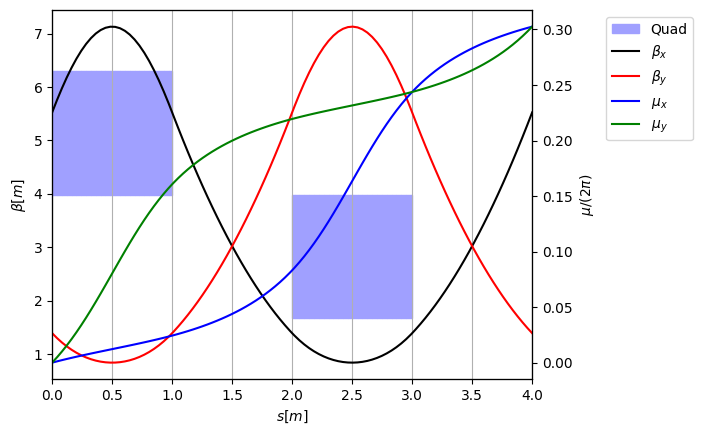

In [9]:
# we added some points to the line
line.cut_at_s(np.linspace(0, 4, 100))
my_twiss = line.twiss4d()
my_twiss.plot(yl = 'betx bety', yr = 'mux muy')

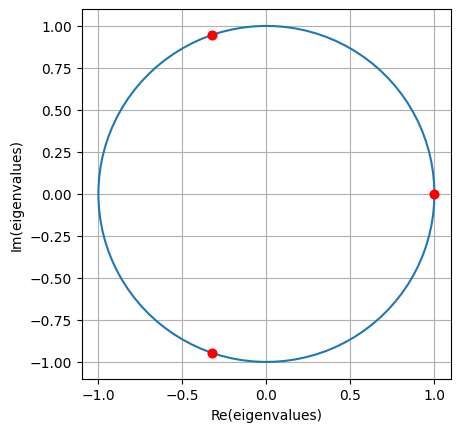

In [10]:
eigs = np.linalg.eigvals(my_twiss.get_R_matrix(start='start', end='end'))
# take the phase advance of the first eigenvector

# plot the circle of radius 1
plt.plot(np.cos(np.linspace(0, 2*np.pi, 100)), np.sin(np.linspace(0, 2*np.pi, 100)))
plt.plot(np.real(eigs), np.imag(eigs), 'or')
plt.axis('square')
plt.grid(True)
plt.xlabel('Re(eigenvalues)')
plt.ylabel('Im(eigenvalues)')
assert np.allclose(np.abs(eigs), 1)

In [11]:
# relation of the phase advance with the eigenvectors
phase_advance = np.angle(eigs[0])
print(phase_advance/(2*np.pi))

0.30254964175929094


### Beam envelopes

Text(0, 0.5, 'Beam sizes [um]')

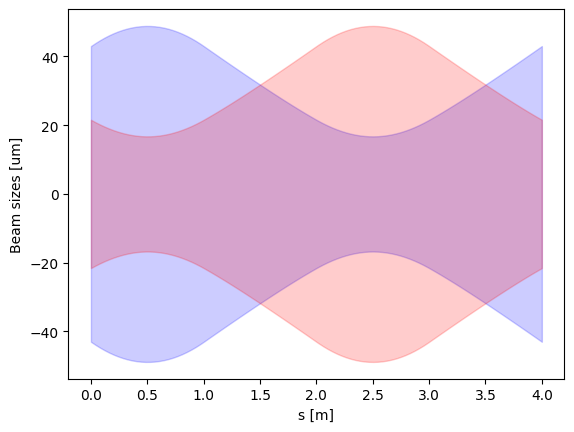

In [12]:
# Transverse normalized emittances
nemitt_x = 2.5e-6
nemitt_y = 2.5e-6

# Longitudinal emittance from energy spread
sigma_pzeta = 2e-4
gemitt_zeta = sigma_pzeta**2 * my_twiss.bets0
# similarly, if the bunch length is known, the emittance can be computed as
# gemitt_zeta = sigma_zeta**2 / tw.bets0

beam_sizes = my_twiss.get_beam_covariance(nemitt_x=nemitt_x,
                                    nemitt_y=nemitt_y,
                                    gemitt_zeta=gemitt_zeta)


# fill region between the two curves
plt.fill_between(beam_sizes['s'], beam_sizes['sigma_x']*1e6, -beam_sizes['sigma_x']*1e6, color='b', alpha=0.2)
plt.fill_between(beam_sizes['s'], beam_sizes['sigma_y']*1e6, -beam_sizes['sigma_y']*1e6, color='r', alpha=0.2)
plt.xlabel('s [m]')
plt.ylabel('Beam sizes [um]')
# 3D plot of the beam sizes sigma_x and sigma_y as a function of s?




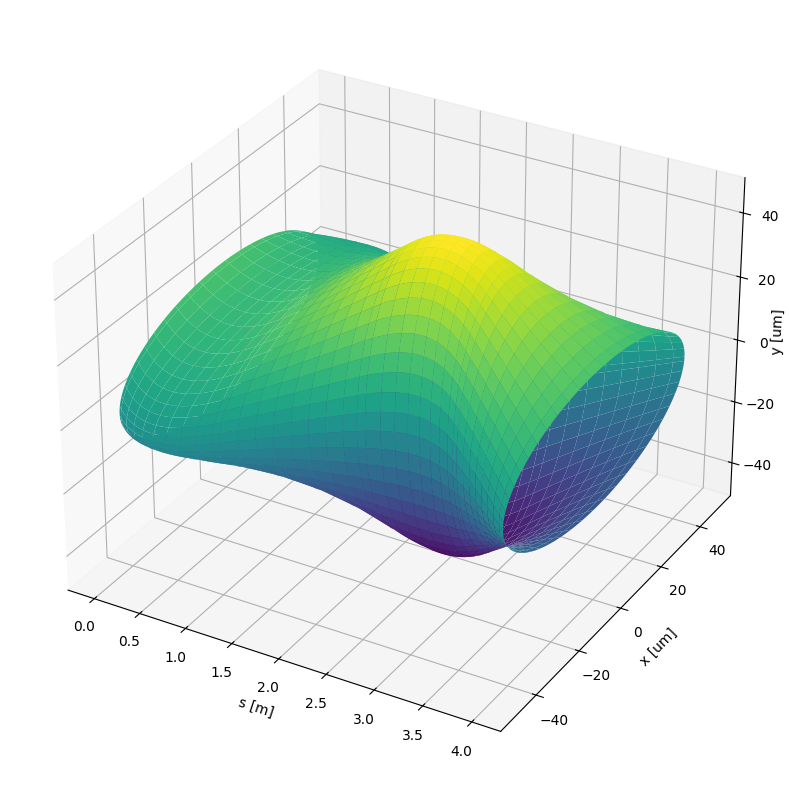

In [13]:

from mpl_toolkits.mplot3d import Axes3D

# Define the range of s
s = beam_sizes.s  # Longitudinal position

# Define sigma_x(s) and sigma_y(s) as functions or arrays
sigma_x = beam_sizes.sigma_x*1e6
sigma_y = beam_sizes.sigma_y*1e6

# Create a meshgrid for theta (angle around the envelope)
theta = np.linspace(0, 2 * np.pi, 100)

# Create the 3D arrays for plotting
S, T = np.meshgrid(s, theta)  # Meshgrid for s and theta

# Parametric equations for the 3D envelope
X = sigma_x * np.cos(T)  # X in the horizontal plane
Y = sigma_y * np.sin(T)  # Y in the vertical plane
Z = S  # Z is the longitudinal axis

# Create the 3D plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface representing the 3D envelope
ax.plot_surface(Z, X, Y, cmap='viridis', alpha=1, shade=True)

# Labels for axes
ax.set_xlabel('s [m]')
ax.set_ylabel('x [um]')
ax.set_zlabel('''y [um]\n\n''')

# Show the plot
plt.show()


### Chromaticity and off-momentum $\beta$-beating

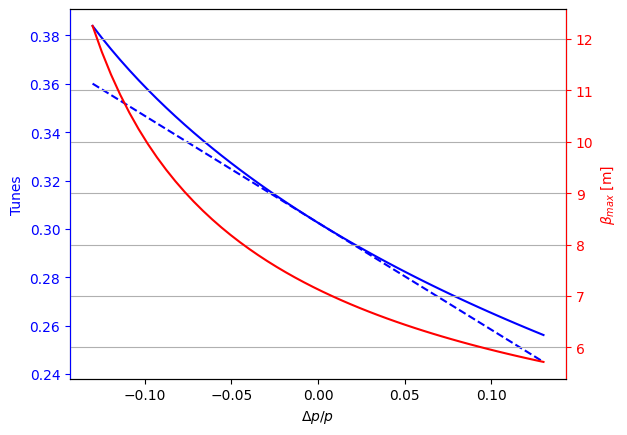

In [14]:
delta_values = np.linspace(-1.3e-1, 1.3e-1, 50)

qx_values = []
beta_max = []
for i, delta in enumerate(delta_values):
    print(f'Xsuite working on {i} of {len(delta_values)}  ', end='\r', flush=True)
    tt = line.twiss(method='4d', delta0=delta)

    qx_values.append(tt.qx) 
    beta_max.append(np.max(tt.betx))

plt.plot(delta_values, qx_values, label='qx', color='b')
plt.gca().tick_params(axis='y', colors='blue')
plt.ylabel('Tunes', color='blue')
plt.xlabel('$\\Delta p/p$')
plt.plot(delta_values, delta_values*my_twiss.dqx+my_twiss.qx, 'b--')

plt.twinx()
plt.plot(delta_values, beta_max, label='$\\beta_{max}$', color='r')
# set in red the y axis and its ticks
plt.gca().spines['right'].set_color('red')
plt.gca().tick_params(axis='y', colors='red')
plt.gca().spines['left'].set_color('blue')

plt.ylabel('$\\beta_{max}$ [m]', color='red')
plt.grid(True)
# plot the line with slope my_twiss.qx


In [15]:
print(f'Qx = {my_twiss.qx}')
print(f'Qy = {my_twiss.qy}')

print(f'DQx (x-chromaticity) = {my_twiss.dqx}')
print(f'DQy (y-chromaticity) = {my_twiss.dqy}')

Qx = 0.3025496417592901
Qy = 0.30254964175929044
DQx (x-chromaticity) = -0.44251119710181364
DQy (y-chromaticity) = -0.4425111970951523


### Tracking particles and volume preservation in linear optics

In [16]:
env['k1'] = 1

# Remeber that the volume of the hyper-cube of the n vecotor is R^n
# is the determinant of their matrix

particles = line.build_particles(
                        x =  [1, 0, 0, 0, 0, 0],
                        px = [0, 1, 0, 0, 0, 0],
                        y =  [0, 0, 1, 0, 0, 0],
                        py = [0, 0, 0, 1, 0, 0],
                        zeta = [0, 0, 0, 0, 1, 0],
                        delta = [0, 0, 0, 0, 0, 1],
)
# Reference mass, charge, energy are taken from the reference particle.
# Particles are allocated on the context chosen for the line.

## Track (saving turn-by-turn data)
n_turns = 100000
line.track(particles, num_turns=n_turns, freeze_longitudinal=True,
              turn_by_turn_monitor=True)


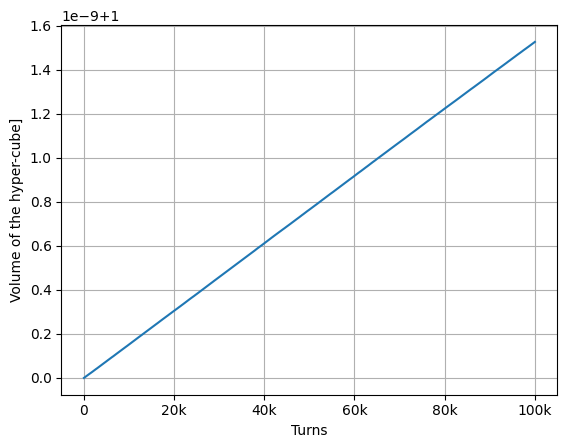

In [17]:
# vertical concatenated array
my_det = []
for turn in range(n_turns):
    V_matrix = np.vstack([line.record_last_track.x[:,turn],
            line.record_last_track.px[:,turn],
            line.record_last_track.y[:,turn],
            line.record_last_track.py[:,turn],
            line.record_last_track.zeta[:,turn],
            line.record_last_track.delta[:,turn],
            ])
    my_det.append(np.linalg.det(V_matrix))

plt.plot(my_det)

plt.xlabel('Turns')
plt.ylabel('Volume of the hyper-cube]')
plt.grid(True)

plt.xticks(np.arange(0, 100001, 20000), ['0', '20k', '40k', '60k', '80k', '100k']);


### The problem of stability

In [22]:
# Create an environment
# switch off the warning for the moment
import warnings
warnings.filterwarnings('ignore')
env = xt.Environment()

env['k1'] = 1
env['k2'] = 1


# Build the simplest stable lattice
line = env.new_line(components=[
    # a quadrupole of length of 1 [m] and k1 equal to 1 [1/m^2]
    env.new('start', xt.Marker), 
    env.new('q1', xt.Quadrupole, length=1, k1='k1'), 
    # a drift of length of 1 [m]
    env.new('drift_1',  xt.Drift, length=1),
    env.new('q2', xt.Quadrupole, length=1, k1='k2'),
    env.new('drift_2',  xt.Drift, length=1),
    env.new('end', xt.Marker), 
])

# Define reference particle
line.particle_ref = xt.Particles(p0c=7e12, mass0=xt.PROTON_MASS_EV)
kf_list = []
kd_list = []
stable_list = []

for ii in range(5000):
    try:
        env['k1'] = np.random.uniform(-1.5,1.5)
        env['k2'] = np.random.uniform(-1.5,1.5)
        kf_list.append(env['k1'])
        kd_list.append(env['k2'])
        stable_list.append(1)
        line.twiss4d()
    except:
        stable_list[-1] = 0


Text(0.5, 1.0, 'Stability diagram: in yellow the (k1,k2) of the stable lattices')

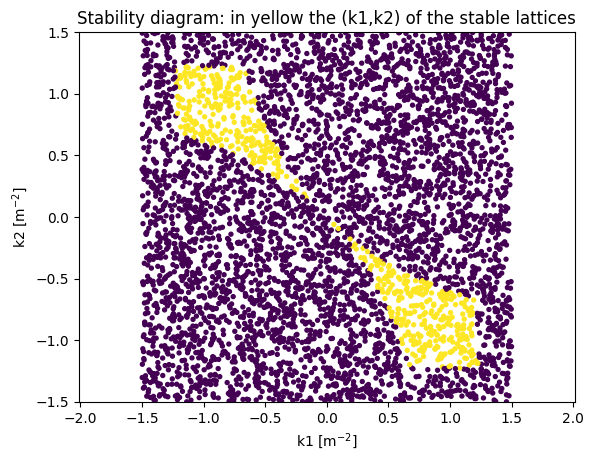

In [23]:
#  scatter plot using kf_list and kf_list and coloring the points according to stable_list
plt.scatter(kf_list, kd_list, c=stable_list, alpha=1, s=8)

plt.axis('equal')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel('k1 [m$^{-2}$]')
plt.ylabel('k2 [m$^{-2}$]')
plt.title('Stability diagram: in yellow the (k1,k2) of the stable lattices')